In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow import initializersalizers as initer

import pandas as pd
import numpy as np


In [4]:
data_dir = './datasets/housing_kaggle/'
df_train = pd.read_csv(data_dir + 'kaggle_house_pred_train.csv')
df_test = pd.read_csv(data_dir + 'kaggle_house_pred_test.csv')
print(df_train.shape, df_test.shape)
print(df_train.columns)
print(df_train.head())
print(df_test.head())

(1460, 81) (1459, 80)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'Ga

In [18]:
X_all = pd.concat([
    df_train.iloc[:, 1:-1],
    df_test.iloc[:, 1:]
])
features_numeric = X_all.dtypes[X_all.dtypes != 'object'].index
print(features_numeric)
X_all[features_numeric] = X_all[features_numeric].apply(
    lambda x: (x - x.mean()) / x.std()
).fillna(0)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [20]:
X_all = pd.get_dummies(X_all, dummy_na=True)
print(X_all.shape)
print(X_all.columns)

(2919, 331)
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_Oth', 'SaleType_WD', 'SaleType_nan', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleCondition_nan'],
      dtype='object', length=331)


In [25]:
n_train = df_train.shape[0]
X_train = X_all[:n_train].values
X_test = X_all[n_train:].values
y_train = df_train['SalePrice'].values.reshape(-1, 1)

In [26]:
def get_net():
    net = keras.Sequential([
        keras.layers.Dense(1)
    ])
    return net

In [27]:
log_rmse = keras.losses.MeanSquaredLogarithmicError()

In [37]:
def get_k_fold_data(X, y, k, i):
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j+1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_val, y_val = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], axis=0)
            y_train = tf.concat([y_train, y_part], axis=0)
    return X_train, y_train, X_val, y_val

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        # create model
        data = get_k_fold_data(X_train, y_train, k, i)
        net=get_net()
        # Compile model
        net.compile(
            loss=tf.keras.losses.mean_squared_logarithmic_error, 
            optimizer=tf.keras.optimizers.Adam(learning_rate)
        )
        # Fit the model
        history=net.fit(
            data[0], data[1],
            validation_data=(data[2], data[3]), 
            epochs=num_epochs, batch_size=batch_size,
            validation_freq=1,verbose=0
        )
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        print('fold %d, train rmse %f, valid rmse %f'
              % (i, loss[-1], val_loss[-1]))
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='train')
    plt.plot(val_loss, label='valid')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


fold 0, train rmse 10.019002, valid rmse 9.992577
fold 1, train rmse 9.482807, valid rmse 9.251543
fold 2, train rmse 6.761796, valid rmse 6.687151
fold 3, train rmse 12.176863, valid rmse 12.103842
fold 4, train rmse 8.495340, valid rmse 8.521495


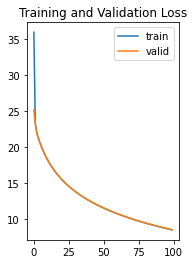

In [38]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
k_fold(k, X_train, y_train, num_epochs,lr, weight_decay, batch_size)


In [41]:
x_train=tf.convert_to_tensor(X_train,dtype=tf.float32)
y_train=tf.convert_to_tensor(y_train,dtype=tf.float32)
x_test=tf.convert_to_tensor(X_test,dtype=tf.float32)
model=tf.keras.models.Sequential([
  tf.keras.layers.Dense(1)
])
adam=tf.keras.optimizers.Adam(0.5)
model.compile(optimizer=adam,
              loss=tf.keras.losses.mean_squared_logarithmic_error
              )
model.fit(x_train, y_train, epochs=200,batch_size=32,verbose=0)
preds=np.array(model.predict(x_test))
df_test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
submission = pd.concat([df_test['Id'], df_test['SalePrice']], axis=1)
submission.to_csv('submission.csv', index=False)
